# OPTUNA 

MIT licence.

3 principaux objectifs :
1. Construction de l'espace de recherche de façon dynamique (*define-by-run API*)
2. Implémentation efficiente de la recherche mais également du *pruning* (c'est-à-dire quand des branches entières de l'espace de recherche sont supprimées)
3. Utilisation simple allant de l'architecture légère à l'architecture extensible et distribuée.



To install : 

```shell
conda create -n optunenv python=3.9
conda install -c conda-forge optuna
conda install pandas
conda install pytorch torchvision torchaudio cpuonly -c pytorch
conda install -c anaconda scikit-learn
```

In [66]:
import pandas as pd
from pathlib import Path
from functools import partial
import numpy as np
import sklearn.datasets
import sklearn.ensemble
import sklearn.model_selection
import sklearn.svm
import scipy
import torch
import mytorch
import optuna

seed = 42

# path_to_train_data = Path("data/Earthquakes_TRAIN.txt")
# path_to_test_data = Path("data/Earthquakes_TEST.txt")

def create_data(nb_samples, sample_length, max_frequency, pb_frequency, percentage_present=0.5):
    # we want to identify if one specific frequency is present in the signal
    x = np.random.random(size=(nb_samples, max_frequency))
    targets = np.random.binomial(n=1, p=percentage_present, size=nb_samples)
    x[~targets.astype(bool), pb_frequency-1] = 0.
    x[targets.astype(bool), pb_frequency-1] = 10 * x[targets.astype(bool), pb_frequency-1]

    signals = np.zeros(shape=(nb_samples, sample_length))
    for i, x_ in enumerate(x):
        signals[i] = scipy.fft.irfft(x_, n=sample_length)

    return signals, targets

nb_sample_train = 200
nb_sample_test = 50
sample_length = 100
max_frequency = 2
pb_frequency = 2
x_train, y_train = create_data(nb_sample_train, sample_length, max_frequency, pb_frequency)
x_test, y_test = create_data(nb_sample_test, sample_length, max_frequency, pb_frequency)

# arr_train = np.loadtxt(path_to_train_data)
# arr_test = np.loadtxt(path_to_test_data)
# limit = 300
# limit_y = 50
# arr_train = arr_train[:limit]
# y_train = arr_train[:, 0].astype(int)
# x_train = arr_train[:, -limit_y:]
# y_test = arr_test[:, 0].astype(int)
# x_test = arr_test[:, -limit_y:] # 1:
# print(x_train.shape)

In [67]:
df = pd.DataFrame(data=x_train.T)

In [68]:
df

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,0.009773,0.042904,0.00587,0.005849,0.002606,0.007111,0.004989,0.004695,0.004487,0.007252,...,0.00663,0.002954,0.000632,0.000922,0.007215,0.003386,0.053086,0.147476,0.176501,0.002912
1,0.009773,0.042830,0.00587,0.005849,0.002606,0.007111,0.004989,0.004695,0.004487,0.007252,...,0.00663,0.002954,0.000632,0.000922,0.007215,0.003386,0.053000,0.147187,0.176156,0.002912
2,0.009773,0.042609,0.00587,0.005849,0.002606,0.007111,0.004989,0.004695,0.004487,0.007252,...,0.00663,0.002954,0.000632,0.000922,0.007215,0.003386,0.052742,0.146321,0.175122,0.002912
3,0.009773,0.042241,0.00587,0.005849,0.002606,0.007111,0.004989,0.004695,0.004487,0.007252,...,0.00663,0.002954,0.000632,0.000922,0.007215,0.003386,0.052314,0.144883,0.173402,0.002912
4,0.009773,0.041729,0.00587,0.005849,0.002606,0.007111,0.004989,0.004695,0.004487,0.007252,...,0.00663,0.002954,0.000632,0.000922,0.007215,0.003386,0.051717,0.142876,0.171005,0.002912
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.009773,0.041073,0.00587,0.005849,0.002606,0.007111,0.004989,0.004695,0.004487,0.007252,...,0.00663,0.002954,0.000632,0.000922,0.007215,0.003386,0.050954,0.140310,0.167938,0.002912
96,0.009773,0.041729,0.00587,0.005849,0.002606,0.007111,0.004989,0.004695,0.004487,0.007252,...,0.00663,0.002954,0.000632,0.000922,0.007215,0.003386,0.051717,0.142876,0.171005,0.002912
97,0.009773,0.042241,0.00587,0.005849,0.002606,0.007111,0.004989,0.004695,0.004487,0.007252,...,0.00663,0.002954,0.000632,0.000922,0.007215,0.003386,0.052314,0.144883,0.173402,0.002912
98,0.009773,0.042609,0.00587,0.005849,0.002606,0.007111,0.004989,0.004695,0.004487,0.007252,...,0.00663,0.002954,0.000632,0.000922,0.007215,0.003386,0.052742,0.146321,0.175122,0.002912


In [69]:
# df['target'] = y_train
df['time'] = np.arange(sample_length)

<AxesSubplot: xlabel='time', ylabel='0'>

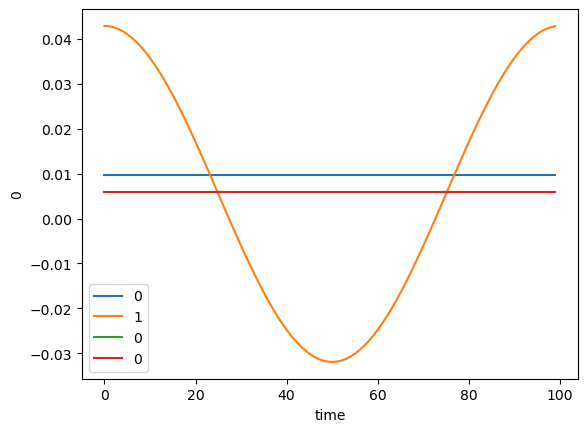

In [70]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, ax = plt.subplots()
sns.lineplot(data=df, x='time', y=0, label=y_train[0])
sns.lineplot(data=df, x='time', y=1, label=y_train[1])
sns.lineplot(data=df, x='time', y=2, label=y_train[2])
sns.lineplot(data=df, x='time', y=3, label=y_train[3])

In [72]:
print(y_test)

[1 0 1 1 1 0 1 0 0 1 0 0 0 1 1 1 0 0 1 1 1 1 1 0 0 1 0 1 1 1 0 0 1 1 0 0 1
 0 0 1 0 1 1 0 1 0 0 1 1 0]


In [73]:
number_of_layers = [1, 2, 3, 4]
hidden_sizes = [1, 2, 3, 4]
lr_list = [1e-1, 1e-2, 1e-3, 1e-4]
batch_sizes = [4, 8, 16]

Let's start by defining the data, models, metrics used to illustrate OPTUNA.

In [74]:
model_class = partial(mytorch.TimeSeriesClassificationNet, input_size=1, number_of_classes=2, activation_fn='sigmoid')

In [75]:
model = model_class(hidden_size=3, num_layers=2)
# mytorch.train(model, x_train, y_train, lr_list[3], epochs=10, batch_size=batch_sizes[2], device=torch.device('cpu'))

In [76]:
classifier_obj = mytorch.TorchClassifier(model, 1e-4, epochs=10, batch_size=batch_sizes[2])

In [77]:
classifier_obj.fit(x_train, y_train)

100%|██████████| 10/10 [00:04<00:00,  2.11it/s]


In [78]:
pred = classifier_obj.predict(x_test)

In [79]:
pred

array([[0.5267868 , 0.5630057 ],
       [0.5278972 , 0.5672341 ],
       [0.52776736, 0.56673956],
       [0.5265763 , 0.5622047 ],
       [0.52710056, 0.5641997 ],
       [0.5279435 , 0.5674107 ],
       [0.52745986, 0.565568  ],
       [0.52789587, 0.56722915],
       [0.5278942 , 0.56722265],
       [0.52661175, 0.56233954],
       [0.5278891 , 0.5672034 ],
       [0.52792895, 0.5673553 ],
       [0.5278901 , 0.567207  ],
       [0.5269742 , 0.56371874],
       [0.5267629 , 0.56291485],
       [0.5277787 , 0.5667826 ],
       [0.5279393 , 0.56739485],
       [0.5279025 , 0.5672543 ],
       [0.5277954 , 0.56684613],
       [0.52730364, 0.56497306],
       [0.5276548 , 0.56631064],
       [0.52753425, 0.5658512 ],
       [0.5268062 , 0.5630793 ],
       [0.527902  , 0.56725246],
       [0.52790093, 0.5672486 ],
       [0.5278075 , 0.56689227],
       [0.5279556 , 0.56745684],
       [0.5276559 , 0.56631476],
       [0.52763903, 0.5662504 ],
       [0.52672225, 0.5627602 ],
       [0.

In [80]:
classifier_obj.score(x_train, y_train)

0.505

In [81]:
classifier_obj.score(x_test, y_test)

0.54

In [82]:
def objective_(trial, x, y):
    classifier_name = trial.suggest_categorical('classifier', ['SVR', 'RandomForest', 'GRU-classification-head'])
    if(classifier_name == 'SVR'):
        svr_c = trial.suggest_float('svr_c', 1e-10, 1e10, log=True)
        classifier_obj = sklearn.svm.SVC(C=svr_c)
    elif(classifier_name  == 'RandomForest'):
        rf_max_depth = trial.suggest_int('rf_max_depth', 2, 32)
        classifier_obj = sklearn.ensemble.RandomForestClassifier(max_depth=rf_max_depth)
    else:
        hidden_size = trial.suggest_int('hidden_size', 1, 8)
        num_layers = trial.suggest_int('num_layers', 1, 8)
        lr = trial.suggest_float('lr', 1e-5, 1, log=True)
        epochs = 10
        batch_size = 8
        model = model_class(hidden_size=hidden_size, num_layers=num_layers)
        classifier_obj = mytorch.TorchClassifier(model, lr, epochs, batch_size)

    x_train, x_valid, y_train, y_valid = sklearn.model_selection.train_test_split(x, y, train_size=0.5, random_state=0)
    classifier_obj.fit(x_train, y_train)
    score = classifier_obj.score(x_valid, y_valid)
    return 1.0 - score

objective = partial(objective_, x=x_train, y=y_train)
study = optuna.create_study()  # Create a new study.
study.optimize(objective, n_trials=100, timeout=60)  # Invoke optimization of the objective function.

[I 2023-01-29 19:05:08,735] A new study created in memory with name: no-name-247ba603-5ce7-4a61-87fd-3af02f6516c3
[I 2023-01-29 19:05:08,813] Trial 0 finished with value: 0.0 and parameters: {'classifier': 'RandomForest', 'rf_max_depth': 27}. Best is trial 0 with value: 0.0.
100%|██████████| 10/10 [00:06<00:00,  1.53it/s]
[I 2023-01-29 19:05:15,345] Trial 1 finished with value: 0.52 and parameters: {'classifier': 'GRU-classification-head', 'hidden_size': 4, 'num_layers': 3, 'lr': 0.06270893552062051}. Best is trial 0 with value: 0.0.
[I 2023-01-29 19:05:15,429] Trial 2 finished with value: 0.0 and parameters: {'classifier': 'RandomForest', 'rf_max_depth': 17}. Best is trial 0 with value: 0.0.
100%|██████████| 10/10 [00:11<00:00,  1.16s/it]
[I 2023-01-29 19:05:27,090] Trial 3 finished with value: 0.48 and parameters: {'classifier': 'GRU-classification-head', 'hidden_size': 7, 'num_layers': 5, 'lr': 0.0007463471057051581}. Best is trial 0 with value: 0.0.
[I 2023-01-29 19:05:27,095] Tria

KeyboardInterrupt: 

In [ ]:
from tqdm import tqdm

In [ ]:
tqdm()